In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import spatial
from collections import Counter
import seaborn as sns

In [133]:
ratings_train = pd.read_csv("hw4-data/ratings.csv", names=["user_id", "movie_id", "rating"])

In [136]:
#spread so that users are rownames, movies are colnames
M_df = ratings_train.pivot(index="user_id", columns="movie_id", values="rating")
M = np.array(M_df)

In [126]:
def log_joint_likelihood(sigmasq, lam, M, U, V): #this is the MAP objective function
    #M should be ndarray
    #U is an dxN1 array. calling it T because each row corresponds to uiT in eqns
    #V is dxN2 array
    ##ui, vi should be np column vectors
    term1 = -1/(2*sigmasq)*np.sum(np.nan_to_num(np.square(np.subtract(M, np.matmul(np.transpose(U),V))))) #should add an NA wherever there is missing an M, which takes care of staying in omega - need to make sure NA's are handled properly
    term2 = -lam/2*np.sum(np.square(U))
    term3 = -lam/2*np.sum(np.square(V))
    return(term1 + term2 + term3)

def update_ui(i, lam, sigmasq, d, omega_ui, V):
    #V is dxN2 array
    sum_outer_prods = sum( [np.dot(V[:,j].reshape(-1,1), np.transpose(V[:,j].reshape(-1,1))) for j in omega_ui] )
    term1 = np.linalg.inv(np.add(lam*sigmasq*np.eye(d), sum_outer_prods))
    term2 = sum( [np.dot(M[i,j], V[:,j].reshape(-1,1)) for j in omega_ui] )
    updated_ui = np.matmul(term1, term2)
    return(updated_ui) #returns a dx1 column vector

def update_vj(j, lam, sigmasq, d, omega_vj, U):
    #U is dxN1 array
    sum_outer_prods = sum( [np.dot(U[:,i].reshape(-1,1), np.transpose(U[:,i].reshape(-1,1))) for i in omega_vj] )
    term1 = np.linalg.inv(np.add(lam*sigmasq*np.eye(d), sum_outer_prods))
    term2 = sum( [np.dot(M[i,j], U[:,i].reshape(-1,1)) for i in omega_vj] )
    updated_vj = np.matmul(term1, term2)
    return(updated_vj) #returns a dx1 column vector

In [127]:
#parameters
lam = 1
sigmasq = 0.25
d = 10

In [128]:
#find omega_ui
omega_ui = [np.where(x)[0] for x in np.logical_not(np.isnan(M))] #need index 0 bc it returns a tuple for some unknown reason

#find omega_vj
omega_vj = [np.where(x)[0] for x in np.transpose(np.logical_not(np.isnan(M)))] #need index 0 bc it returns a tuple for some unknown reason

In [189]:
##data structures to hold results from each round
all_obj = {}
all_RMSE = {}
all_V = {}

n_iter = 100; #how many iterations during model training

for round in range(10):
    ##MAP coordinate ascent algorithm
    initial_V = np.transpose(np.random.multivariate_normal(np.zeros(10), np.eye(d), size=(M.shape[1])))
    v = initial_V
    obj = []
    for iter in range(n_iter):
        u = np.transpose(np.array([update_ui(i, lam, sigmasq, d, omega_ui[i], v) for i in range(M.shape[0])]).reshape(-1,d)) #need to transpose in order to get it back to a d x N1 matrix
        v = np.transpose(np.array([update_vj(j, lam, sigmasq, d, omega_vj[j], u) for j in range(M.shape[1])]).reshape(-1,d)) #need to transpose in order to get it back to a d x N1 matrix
        if iter >= 1:
            obj.append(log_joint_likelihood(sigmasq, lam, M, u, v))
    all_V["round"+str(round)] = v
    all_obj["round"+str(round)] = obj
    
    ##plot
    plt.plot(range(2,(n_iter+1), obj)

    ##calculate RMSE test set`
    predictions = np.dot(np.transpose(u), v)
    ratings_test = pd.read_csv("hw4-data/ratings_test.csv", names=["user_id", "movie_id", "rating"])
    ratings_test = ratings_test[ratings_test.movie_id.isin(M_df.columns.values)] #filter test to movies included in training (all users are found in training)   
    test_user_inds = [M_df.index.get_loc(test_user) for test_user in ratings_test.user_id.values]
    test_movie_inds = [M_df.columns.get_loc(test_movie) for test_movie in ratings_test.movie_id.values]
    ratings_test['prediction'] = predictions[test_user_inds, test_movie_inds]
    all_RMSE["round"+str(round)] = np.sqrt(np.mean(np.square(np.subtract(ratings_test.rating.values, ratings_test.prediction.values))))

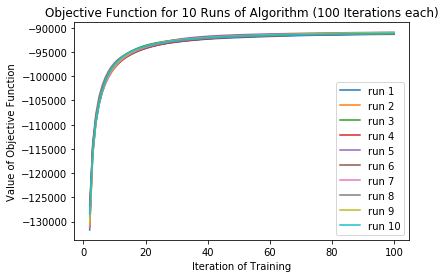

In [190]:
plt.xlabel("Iteration of Training")
plt.ylabel("Value of Objective Function")
plt.legend(["run " + i for i in [str(j) for j in range(1,11)]])
plt.title("Objective Function for 10 Runs of Algorithm (100 Iterations each)")
plt.show()

In [353]:
final_values = pd.DataFrame({"Final Value Objective Func" : [all_obj[x][n_iter-2] for x in all_obj], 
                             "RMSE" : [all_RMSE[x] for x in all_RMSE]}, index = ["run " + i for i in [str(j) for j in range(1,11)]])
final_values.sort_values('Final Value Objective Func', ascending=False)

,Final Value Objective Func,RMSE
run 5,-90920.944242,1.099170
run 9,-90973.581990,1.099235
run 2,-91043.595610,1.120456
run 10,-91150.280993,1.110056
run 7,-91150.649560,1.120586
run 4,-91233.660803,1.134907
run 8,-91248.360135,1.087196
run 3,-91270.889453,1.123257
run 6,-91298.358491,1.143245
run 1,-91349.274275,1.113955


In [232]:
max([all_obj[x][n_iter-2] for x in all_obj]) #round4 (labeled "run5" on plot, table) had the highest objective function

-90920.944241767196

In [305]:
movies = pd.read_table("hw4-data/movies.txt", header = None, names=['movie'])
movies.reset_index(inplace=True) #row number is movie id, dif number of movies in this and in our training data so need to add the key as a feature (cant simply index)
movies['movie_id'] = movies.index+1 #bc index starts at 0
movies = movies[movies.movie_id.isin(M_df.columns.values)] #filter test to movies included in training (all users are found in training)   
movies

,index,movie,movie_id
0,0,Toy Story (1995),1
1,1,GoldenEye (1995),2
2,2,Four Rooms (1995),3
3,3,Get Shorty (1995),4
4,4,Copycat (1995),5
5,5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,6
6,6,Twelve Monkeys (1995),7
7,7,Babe (1995),8
8,8,Dead Man Walking (1995),9
9,9,Richard III (1995),10


In [282]:
v = all_V['round4']
print(v.shape)
dists = spatial.distance.squareform(spatial.distance.pdist(np.transpose(v))) #finds distance bw rows,so must tranpose first 
print(dists.shape)

(10, 1676)
(1676, 1676)


In [346]:
closest_movies_dfs = {}
for movie in ['Star Wars', 'My Fair Lady', 'GoodFellas']:
    movie_id = int(movies[movies.movie.str.contains(movie)]['movie_id']) #np.nonzero(movie_mappings.movie.str.contains(movie))[0][0]
    movie_ind = M_df.columns.get_loc(movie_id)
    inds_of_closest_neighbs = np.argsort(dists[movie_ind,])[1:11]
    closest_neighbs_ids = M_df.columns[inds_of_closest_neighbs]
    closest_movies_dfs[movie] = pd.DataFrame({"Closest Movies" : movies[movies.movie_id.isin(closest_neighbs_ids)]['movie'], "Distance" : np.sort(dists[movie_ind,])[1:11]})

In [351]:
closest_movies_dfs['Star Wars']

,Closest Movies,Distance
95,Terminator 2: Judgment Day (1991),0.304748
171,"Empire Strikes Back, The (1980)",0.502703
173,Raiders of the Lost Ark (1981),0.647912
180,Return of the Jedi (1983),0.870934
194,"Terminator, The (1984)",0.892668
203,Back to the Future (1985),0.929025
209,Indiana Jones and the Last Crusade (1989),0.957644
428,"Day the Earth Stood Still, The (1951)",0.966905
1006,Waiting for Guffman (1996),0.974156
1268,Love in the Afternoon (1957),0.985527


In [348]:
closest_movies_dfs['My Fair Lady']

,Closest Movies,Distance
7,Babe (1995),0.768321
132,Gone with the Wind (1939),0.801736
142,"Sound of Music, The (1965)",0.858096
416,"Parent Trap, The (1961)",0.858263
418,Mary Poppins (1964),0.934540
601,"American in Paris, An (1951)",0.941190
605,All About Eve (1950),0.944712
628,Victor/Victoria (1982),0.981944
706,Enchanted April (1991),0.997569
1146,My Family (1995),1.011438


In [349]:
closest_movies_dfs['GoodFellas']

,Closest Movies,Distance
126,"Godfather, The (1972)",0.532443
176,"Good, The Bad and The Ugly, The (1966)",0.670239
179,Apocalypse Now (1979),0.674657
184,Psycho (1960),0.685926
186,"Godfather: Part II, The (1974)",0.719666
187,Full Metal Jacket (1987),0.750065
503,Bonnie and Clyde (1967),0.757353
507,"People vs. Larry Flynt, The (1996)",0.893697
645,Once Upon a Time in the West (1969),0.914318
692,Casino (1995),0.919381
